In [1]:
import torch
from torchvision.transforms import RandomCrop, Resize
from PIL import Image
from sklearn.datasets import fetch_lfw_people
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset = fetch_lfw_people(data_home="faces")
# pairs_generator()

In [3]:
data, images = dataset["data"], dataset["images"]
n = data.shape[0]

In [4]:
def pairs_generator(to_torch=False):
    bigcropper = RandomCrop(size=(40,40))
    resizer = Resize(size=(20,20))
    for image in map(Image.fromarray, images):
        big = bigcropper(image)
        small = resizer(big)
        if to_torch:
            yield tuple(map(lambda img: torch.from_numpy(np.array(img)), (small, big)))       
        else:
            yield tuple(map(np.array, (small, big)))    

In [5]:
def raw_batch_generator(batch_size=32):
    generator = pairs_generator(to_torch=True)
    for i in range(n//batch_size):
        yield [next(generator) for i in range(batch_size)]

def images_and_labels_generator(batch_size=32):
    for batch in raw_batch_generator(batch_size):
        images, labels = [], []
        for (small, big) in batch:
            images.append(small)
            labels.append(big)
        batch_images = torch.stack(images, dim=0).unsqueeze(1)
        batch_labels = torch.stack(labels, dim=0).unsqueeze(1)
        yield batch_images, batch_labels

In [6]:
# gen = raw_batch_generator()
# for i, _ in enumerate(gen):
#     print(i)
data.shape

(13233, 2914)

In [7]:
x, y = next(images_and_labels_generator())

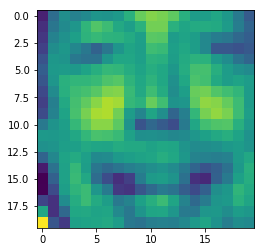

In [8]:
plt.imshow(x[0, 0, :, :])

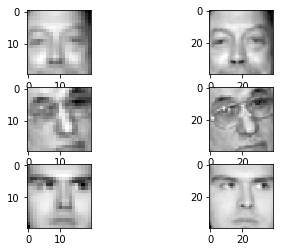

In [9]:
nrows, ncols = (3,2)
# def 
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
for i, (small, big) in enumerate(pairs_generator()):
    ax1, ax2 = axs[i]
    ax1.imshow(small, cmap=plt.cm.gray)
    ax2.imshow(big, cmap=plt.cm.gray)
    if i + 1 >= nrows:
        break

In [10]:
from torch import nn
class Net(nn.Module):
    def __init__(self, upscale):
        super(Net, self).__init__()
        self.relu = nn.ReLU()
#         self.batch_norm = nn.BatchNorm2d(64)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), padding=(2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), padding=(1, 1))
        self.conv21 = nn.Conv2d(64, 64, (3, 3), padding=(1, 1))
        self.conv22 = nn.Conv2d(64, 64, (3, 3), padding=(1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), padding=(1, 1))
        self.conv4 = nn.Conv2d(32,  32**upscale, (3, 3), padding=(1,1))
        self.pixel_shuffle1 = nn.PixelShuffle(upscale)
        self.conv5 = nn.Conv2d(256, 1, (3,3), padding=(1,1))
        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv21(x))
        x = self.relu(self.conv22(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle1(self.conv4(x))
        x = self.conv5(x)
        return x

    def _initialize_weights(self):
        init = nn.init
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)
        init.orthogonal_(self.conv5.weight)

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [12]:
net = Net(upscale=2).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), amsgrad=True)

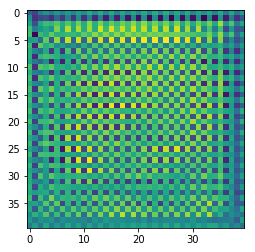

In [13]:
# net.forward(x.to(device)).shape
z = net.forward(x.to(device)).cpu().detach()[0, 0, :, :]
plt.imshow(z)

In [14]:
z.shape, y[0,0,:,:].shape

(torch.Size([40, 40]), torch.Size([40, 40]))

In [15]:
def psnr(mse): 
    return 10 * np.log10(1 / mse)

In [16]:
errs, metrics = list(), list()
for epoch in range(1):
    print("Epoch {} started".format(epoch))
    net.train()
    for i, (data, target) in enumerate(images_and_labels_generator(64)):
        optimizer.zero_grad()
        
        batch_features = data.to(device)
        batch_labels = target.to(device)
        
        batch_preds = net.forward(batch_features)
#         print(batch_preds.shape)
        loss = criterion(batch_preds, batch_labels)
        loss.backward()
        optimizer.step()
        
        if i % 50 == 0:
            err = loss.item()
            metric = psnr(err)
            errs.append(err)
            metrics.append(metric)
            print("Batch {} loss {}, ".format(i, err), end=" ")
            print("psnr: {}".format(metric))

Epoch 0 started
Batch 0 loss 18451.125,  psnr: -42.66022851058601
Batch 50 loss 621.801025390625,  psnr: -27.936514338878148
Batch 100 loss 182.7587127685547,  psnr: -22.618780905114725
Batch 150 loss 101.59245300292969,  psnr: -20.068614467183554
Batch 200 loss 66.6784896850586,  psnr: -18.239857541902587


In [17]:
pred, answ = net.forward(x.to(device)).cpu().detach()[0, 0, :, :], y[0, 0, :, :]

In [18]:
# for i in range(0, 32, 4):
#     for j in range(0, 32, 4):
#         print(pred[i, j], answ[i, j])

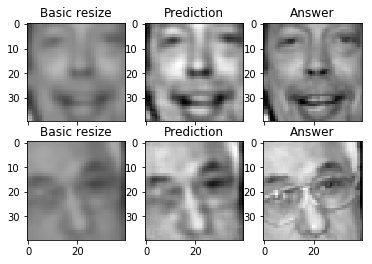

In [21]:
nrows, ncols = (2,3)
pred, answ = net.forward(x.to(device)).cpu().detach()[0:nrows, 0, :, :], y[0:nrows, 0, :, :]
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True)
for i, (prd, ans) in enumerate(zip(pred, answ)):
    ax1, ax2, ax3 = axs[i]
    resizer = Resize(size=(40,40))
    img = Image.fromarray(x[i, 0, :, :].numpy())
    ax1.imshow(resizer(img))
    ax1.set_title("Basic resize")
    ax2.imshow(prd, cmap=plt.cm.gray)
    ax2.set_title("Prediction")
    ax3.imshow(ans, cmap=plt.cm.gray)
    ax3.set_title("Answer")
    if i + 1 >= nrows:
        break